In [1]:
!uv pip install scikit-image

Using Python 3.12.8 environment at: /home/taylor/code/ExtremeWeatherBench/.venv
Audited 1 package in 65ms


In [33]:
import xarray as xr
import numpy as np
import regionmask
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import dataclasses
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from skimage import measure, filters
from typing import Literal
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from itertools import product
from collections import namedtuple
import matplotlib.colors as mcolors
from scipy.ndimage import binary_dilation, label, center_of_mass
import matplotlib.animation as animation

import scores.categorical as cat
from scores.continuous import mae


# Permutation Notes

As I'm writing out the MWE's, here's some notes on what I think might need to be accounted for:

1. Models that run every 3, 6, 12, 24 hours and how that translates to the max/min metrics (all valid times in a 12 hour frequency/6 hour resolution have 21 lead times, for example, compared to 6/6 runs with 41)
2. When to aggregate over lat/lons for area-averaged metrics
3. (TC) To find the local minima, the arrays need to be 2d; cannot roll up to (location, time) until after contours are found

# Main Functions

In [3]:
sat_press_0c = 6.112  # hPa
epsilon = 0.6219569100577033

def mixing_ratio(partial_pressure, total_pressure):
    """Calculates the mixing ratio of a parcel.

    Args:
        partial_press: Partial pressure values
        total_press: Total pressure values

    Returns:
        Mixing ratio values in kg/kg
    """
    return epsilon * partial_pressure / (total_pressure - partial_pressure)

def saturation_mixing_ratio(pressure, temperature):
    """Calculates the saturation mixing ratio of a parcel.

    Args:
        pressure: Pressure values in hPa
        temperature: Temperature values in C

    Returns:
        Saturation mixing ratio values in kg/kg
    """
    return mixing_ratio(saturation_vapor_pressure(temperature), pressure)

def saturation_vapor_pressure(temperature):
    """Calculates the saturation vapor pressure of a parcel.

    Args:
        temperature: Temperature values in Celsius

    Returns:
        Saturation vapor pressure values in hPa
    """
    return sat_press_0c * np.exp(17.67 * temperature / (temperature + 243.5))

def dewpoint_from_vapor_pressure(vapor_pressure):
    """Calculates the dewpoint of a parcel.

    Args:
        vapor_pressure: Vapor pressure values in hPa

    Returns:
        Dewpoint values in C
    """
    val = np.log(vapor_pressure / sat_press_0c)
    return 243.5 * val / (17.67 - val)

def specific_humidity_from_relative_humidity(relative_humidity, temperature, pressure):
    """Calculates the specific humidity of a parcel.

    Args:
        relative_humidity: Relative humidity values in 0-1
        temperature: Temperature values in K
        pressure: Pressure values in hPa

    Returns:
        Specific humidity values in kg/kg
    """
    vapor_pressure = relative_humidity * (saturation_vapor_pressure(temperature-273.15))
    dewpoint = dewpoint_from_vapor_pressure(vapor_pressure)
    mixing_ratio = saturation_mixing_ratio(pressure, dewpoint)
    return mixing_ratio / (1 + mixing_ratio)


In [102]:
def convert_longitude_to_360(longitude: float) -> float:
    """Convert a longitude from the range [-180, 180) to [0, 360)."""
    return np.mod(longitude, 360)

def convert_longitude_to_180(longitude: float) -> float:
    """Convert a longitude from the range [0, 360) to [-180, 180)."""
    return (longitude + 180) % 360 - 180

def calculate_forecast_hours(ds: xr.Dataset) -> np.ndarray:
    """
    Calculate the forecast hours for a dataset.

    Args:
        ds: xr.Dataset with an attribute 'initialization_time'

    Returns:
        xr.Dataset with forecast hours
    """
    forecast_hours = ( 
        (
        ds['time'] - pd.to_datetime(ds.attrs['initialization_time'])
        .to_numpy()
        )
        .values
        .astype('timedelta64[h]')
     )
    return forecast_hours

def lead_time_init_time_to_valid_time(forecast):
    """Convert init_time and lead_time to valid_time.
    
    Args:
        forecast: The forecast dataset.

    Returns:
        The forecast dataset with valid_time dimension.
    """
    if 'lead_time' not in forecast.dims or 'init_time' not in forecast.dims:
        raise ValueError("lead_time and init_time must be dimensions of the forecast dataset")
    
    lead_time_grid, init_time_grid = np.meshgrid(forecast.lead_time, forecast.init_time)
    valid_times = (
    init_time_grid.flatten()
    + pd.to_timedelta(lead_time_grid.flatten(), unit="h").to_numpy()
    )
    return valid_times

# Subset timesteps for forecast
def derive_indices_from_init_time_and_lead_time(
    dataset: xr.Dataset,
    start_date: datetime.datetime,
    end_date: datetime.datetime,
) -> np.ndarray:
    """Derive the indices of valid times in a dataset when the dataset has init_time and lead_time coordinates.

    Args:
        dataset: The dataset to derive the indices from.
        start_date: The start date to derive the indices from.
        end_date: The end date to derive the indices from.

    Returns:
        The indices of valid times in the dataset.

    Example:
        >>> import xarray as xr
        >>> import datetime
        >>> import pandas as pd
        >>> from extremeweatherbench.utils import (
        ...     derive_indices_from_init_time_and_lead_time,
        ... )
        >>> ds = xr.Dataset(
        ...     coords={
        ...         "init_time": pd.date_range("2020-01-01", "2020-01-03"),
        ...         "lead_time": [0, 24, 48],  # hours
        ...     }
        ... )
        >>> start = datetime.datetime(2020, 1, 1)
        >>> end = datetime.datetime(2020, 1, 4)
        >>> indices = derive_indices_from_init_time_and_lead_time(ds, start, end)
        >>> print(indices)
        array([0, 0, 1, 1, 2])
    """
    valid_times = lead_time_init_time_to_valid_time(dataset)
    valid_times_reshaped = valid_times.reshape(
        (
            dataset.init_time.shape[0],
            dataset.lead_time.shape[0],
        )
    )
    valid_time_mask = (valid_times_reshaped > pd.to_datetime(start_date)) & (
        valid_times_reshaped < pd.to_datetime(end_date)
    )
    valid_time_indices = np.asarray(valid_time_mask).nonzero()

    # The first index will subset init_time based on the first valid_time_reshaped line above
    # we don't need to subset lead_time but it might be useful in the future
    init_time_subset_indices = valid_time_indices[0]

    return init_time_subset_indices

def remove_ocean_gridpoints(dataset: xr.Dataset,drop: bool = True) -> xr.Dataset:
    """Subset a dataset to only include land gridpoints based on a land-sea mask.

    Args:
        dataset: The input xarray dataset.

    Returns:
        The dataset masked to only land gridpoints.
    """
    land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    land_sea_mask = land.mask(dataset.longitude, dataset.latitude)
    land_mask = land_sea_mask == 0
    # Subset the dataset to only include land gridpoints
    return dataset.where(land_mask, drop=drop)

def lapl(mat, dx, dy):
    """
    Compute the laplacian using `numpy.gradient` twice.
    """
    grad_y, grad_x = np.gradient(mat, dy, dx)
    grad_xx = np.gradient(grad_x, dx, axis=1)
    grad_yy = np.gradient(grad_y, dy, axis=0)
    return(grad_xx + grad_yy)

def stereographic_laplacian(ds:xr.Dataset, r: float, n: int) -> xr.Dataset:
    """
    Compute the stereographic laplacian of the integrated vapor transport.

    Args:
        ds: The dataset to compute the stereographic laplacian with.
        r: The radius around each gridpoint.
        n: The number of gridpoints to generate.
    """

    multiplicative_operator = 4/(n*r)


def haversine_distance(lat1, lon1, lat2, lon2, output_unit: Literal['km','deg'] = 'km') -> float:
    """
    Calculate the haversine distance between two points on the Earth's surface.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return c * 6371.0 if output_unit == 'km' else np.degrees(c)

def find_n_points_given_radius_in_degrees(lat1, lon1, lat2, lon2, radius_in_degrees) -> float:
    """
    Find n points on a circle in degrees given the latitude and longitude of a point and the radius in degrees.
    """
    output_distance = haversine_distance(lat1, lon1, lat2, lon2, output_unit='deg')
    output_distance = output_distance.sel
    return output_distance

def calculate_pressure_at_surface(geopotential_da: xr.DataArray) -> xr.DataArray:
    """
    Calculate the pressure at the surface of a dataset.
    """
    return 101325*(1-2.25577e-5*geopotential_da/9.80655)**5.25579

In [5]:
def degrees_to_km_at_latitude(degrees: float, latitude: float) -> float:
    """
    Convert a distance in degrees to kilometers at a given latitude.
    
    Args:
        degrees: Distance in degrees
        latitude: Latitude in degrees where the conversion should be done
    
    Returns:
        Distance in kilometers
    """
    # Earth's radius in km
    R = 6371.0
    
    # Convert latitude to radians
    lat = np.radians(latitude)
    
    # At the given latitude, one degree of longitude equals:
    km_per_degree = 2 * np.pi * R * np.cos(lat) / 360.0
    
    return degrees * km_per_degree


def convert_from_cartesian_to_latlon(input_point: np.ndarray, ds_mapping: xr.Dataset) -> tuple[float, float]:
    """Convert a point from the cartesian coordinate system to the lat/lon coordinate system.

    Args:
        input_point: The point to convert, represented as a tuple (y, x) in the cartesian coordinate system.
        ds_mapping: The dataset containing the latitude and longitude coordinates.

    Returns:
        The point in the lat/lon coordinate system, represented as a tuple (latitude, longitude) in degrees.
    """
    return (
        ds_mapping.isel(
            latitude=int(input_point[0]), 
            longitude=int(input_point[1])
            ).latitude.values, 
       
        ds_mapping.isel(
            latitude=int(input_point[0]), 
            longitude=int(input_point[1])
            ).longitude.values
    )

In [6]:
def nantrapz(
    y: np.ndarray,
    x: np.ndarray | None = None,
    dx: float = 1.0,
    axis: int = -1,
):
    y = np.asanyarray(y)
    if x is None:
        d = dx
    else:
        x = np.asanyarray(x)
        if x.ndim == 1:
            d = np.diff(x)
            # reshape to correct shape
            shape = [1] * y.ndim
            shape[axis] = d.shape[0]
            d = d.reshape(shape)
        else:
            d = np.diff(x, axis=axis)
    if y.ndim != d.ndim:
        d = np.expand_dims(d, axis=1)
    nd = y.ndim
    slice1 = [slice(None)] * nd
    slice2 = [slice(None)] * nd
    slice1[axis] = slice(1, None)
    slice2[axis] = slice(None, -1)
    try:
        ret = np.nansum(d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0, axis=axis)
    except ValueError:
        # Operations didn't work, cast to ndarray
        d = np.asarray(d)
        y = np.asarray(y)
        ret = np.add.reduce(d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0, axis)
    return ret

In [203]:
def calculate_ivt_laplacian(ivt_calculated_ds: xr.Dataset) -> xr.DataArray:
    coords_dict = {
        n: v for n, v in sorted(
        ivt_calculated_ds.coords.items(), key=lambda x: ivt_calculated_ds[x[0]].dims[0] if x[0] != 'level' else ''
        ) if n != 'level'
        }
    ivt_calculated_ds['integrated_vapor_transport_laplacian'] = xr.DataArray(
        gaussian_filter(filters.laplace(ivt_calculated_ds['integrated_vapor_transport']),sigma=3),
        coords=coords_dict,
        dims=coords_dict.keys()
    )
    return ivt_calculated_ds

def calculate_ivt(ds: xr.Dataset, q: str = 'specific_humidity', u: str = 'u_component_of_wind', v: str = 'v_component_of_wind') -> xr.DataArray:
    """Calculates the IVT (Integrated Vapor Transport) from a dataset,
    using the method described in Newell et al. 1992 and elsewhere (e.g. Mo 2024).

    Args:
        ds: The input xarray dataset.

    Returns:
        The IVT (Integrated Vapor Transport) quantity.
    """
    coords_dict = {
        dim: ds.coords[dim] for dim in ds.dims if dim != 'level'
        }
    ds['adjusted_level'] = ds['level'].where(ds['level']*100 < ds['surface_standard_pressure'], np.nan)
    if q != 'total_column_water_vapour':
        ds['vertical_integral_of_eastward_water_vapour_flux'] = xr.DataArray(
            nantrapz(ds[u]*ds[q],x=ds.adjusted_level*100,axis=0)/9.80665,
            coords=coords_dict,
            dims=coords_dict.keys()
        )

        ds['vertical_integral_of_northward_water_vapour_flux'] = xr.DataArray(
            nantrapz(ds[v]*ds[q],x=ds.adjusted_level*100,axis=0)/9.80665,
            coords=coords_dict,
            dims=coords_dict.keys()
        )
    else:
        ds['vertical_integral_of_eastward_water_vapour_flux'] = xr.DataArray(
            ds[u]*ds[q],
            coords=coords_dict,
            dims=coords_dict.keys()
        )
        ds['vertical_integral_of_northward_water_vapour_flux'] = xr.DataArray(
            ds[v]*ds[q],
            coords=coords_dict,
            dims=coords_dict.keys()
        )

    ds['integrated_vapor_transport'] = np.sqrt(ds['vertical_integral_of_eastward_water_vapour_flux']**2 + ds['vertical_integral_of_northward_water_vapour_flux']**2)
    ds = calculate_ivt_laplacian(ds)
    return ds

# ivt_ds = calculate_ivt(era5_ivt_test)

In [204]:
def create_atmospheric_river_mask(ds: xr.Dataset) -> xr.DataArray:
    """
    Create a mask for atmospheric rivers based on the integrated vapor transport and its laplacian.

    Args:
        ds: Dataset containing the integrated vapor transport and its laplacian.

    Returns:
        ivt_laplacian_intersection: A mask for atmospheric rivers.
    """
    coords_dict = {
        dim: ds.coords[dim] for dim in ds.dims if dim != 'level'
        }
    # Create boolean masks for each condition
    has_high_laplacian = np.abs(ds['integrated_vapor_transport_laplacian']) >= 2.5
    has_high_ivt = ds['integrated_vapor_transport'] >= 400

    # For the laplacian condition, we want to check if there's a value >= 2.5 within 6 gridpoints
    struct = np.ones((17,17))
    dilated_laplacian = binary_dilation(has_high_laplacian, structure=struct,axes=(1,2))

    # Combine conditions without tropical restriction initially
    initial_intersection = xr.where(
        dilated_laplacian & has_high_ivt,
        1,
        0
    )

    # Label connected components and get their sizes
    labeled_array, num_features = label(initial_intersection)
    unique_labels, label_counts = np.unique(labeled_array, return_counts=True)

    # Filter by size first (excluding background label 0)
    size_valid_labels = unique_labels[np.where((label_counts >= 500) & (unique_labels != 0))]

    # Check centroids of each feature
    valid_features = []
    for label_num in size_valid_labels:
        feature_mask = labeled_array == label_num
        centroid = center_of_mass(feature_mask)
        centroid_lat = ds.latitude[int(centroid[1])]
        if abs(centroid_lat) >= 25:  # Check if centroid is outside tropics
            valid_features.append(label_num)

    # Create final mask using valid features
    feature_mask = np.isin(labeled_array, valid_features)

    # Final result with size threshold and centroid restriction applied
    ivt_laplacian_intersection = xr.DataArray(xr.where(
        feature_mask,
        1,
        0
    ),
    coords=coords_dict,
    dims=coords_dict.keys()
    )
    return ivt_laplacian_intersection

def find_land_intersection(ar_mask: xr.DataArray) -> xr.DataArray:
    """
    Finds points where an atmospheric river mask intersects with land.
    
    Args:
        ar_mask: xarray DataArray containing boolean mask of AR locations
        
    Returns:
        xarray DataArray containing only the points where AR overlaps with land
    """
    mask_parent = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(ar_mask.longitude,ar_mask.latitude)
    mask = mask_parent.where(np.isnan(mask_parent),1).where(mask_parent == 0, 0)
    contingency_manager = cat.BinaryContingencyManager(mask,ar_mask)
    return contingency_manager

# Sample Case Metadata

In [36]:
start_date = pd.Timestamp('2024-11-20 00:00')
end_date = pd.Timestamp('2024-11-22 00:00')

time_range = pd.date_range(start_date, end_date, freq='6h')

@dataclasses.dataclass
class CoordinateBounds:
    min_lat: float
    max_lat: float
    min_lon: float  
    max_lon: float

bounded_location = CoordinateBounds(min_lat=35, max_lat=50, min_lon=230, max_lon=245)


# Load ERA5

In [61]:
#: ERA5 as a standin for forecast
ERA5_URI = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"
era5 = xr.open_zarr(
    ERA5_URI,
    chunks=None,
    storage_options=dict(token="anon"),
)

# Derive mask from ERA5
era5_event_ds = era5.sel(latitude=slice(bounded_location.max_lat,bounded_location.min_lat),longitude=slice(bounded_location.min_lon,bounded_location.max_lon),time=time_range)
era5_event_ds = era5_event_ds[['u_component_of_wind', 
                               'v_component_of_wind',
                               'specific_humidity',
                               'temperature',
                               'vertical_integral_of_northward_water_vapour_flux',
                               'vertical_integral_of_eastward_water_vapour_flux',
                               'total_precipitation'
                               ]].compute()
era5_event_ds['integrated_vapor_transport'] = np.sqrt(
    era5_event_ds['vertical_integral_of_eastward_water_vapour_flux']**2 + era5_event_ds['vertical_integral_of_northward_water_vapour_flux']**2
    )
era5_event_ds = era5_event_ds.transpose('level','time','latitude','longitude')
era5_event_ds = calculate_ivt_laplacian(era5_event_ds)
era5_event_ds['ar_mask'] = create_atmospheric_river_mask(era5_event_ds)
era5_event_ds['ar_land_intersection'] = find_land_intersection(era5_event_ds['ar_mask']).tp


In [ ]:
era5_event_ds['ar_mask'] = create_atmospheric_river_mask(era5_event_ds)
era5_event_ds['ar_land_intersection'] = find_land_intersection(era5_event_ds['ar_mask']).tp

# Load GHCN

In [37]:
#: Storage location for GHCN.
GHCN_URI = "gs://extremeweatherbench/datasets/ghcnh.parq"#Parquet filters

GHCN_URI = "/home/taylor/code/notebooks/ghcnh_20250630.parq"
ghcn_filters = [('time', '>=', start_date - pd.Timedelta(days=2)),
           ('time', '<=', end_date + pd.Timedelta(days=2)),
           ('latitude', '<=', bounded_location.max_lat),
           ('latitude', '>=', bounded_location.min_lat),
           ('longitude', '<=', convert_longitude_to_180(bounded_location.max_lon)),
           ('longitude', '>=', convert_longitude_to_180(bounded_location.min_lon))]
ghcn = pd.read_parquet(GHCN_URI, filters=ghcn_filters).set_index(
[
    "station",
    "time"
]
).sort_index()

#Convert parquet to dataset

ghcn_ds = xr.Dataset.from_dataframe(ghcn)
ghcn_ds['latitude'] = ghcn_ds['latitude'].where(ghcn_ds['latitude'].notnull()).bfill(dim='time').isel(time=0)
ghcn_ds['longitude'] = ghcn_ds['longitude'].where(ghcn_ds['longitude'].notnull()).bfill(dim='time').isel(time=0)
ghcn_ds = ghcn_ds.assign_coords(latitude=ghcn_ds.latitude.astype(float), longitude=ghcn_ds.longitude.astype(float)) 
ghcn_ds['longitude'] = convert_longitude_to_360(ghcn_ds['longitude'])
ghcn_ds = ghcn_ds.rename({'time':'valid_time'}).swap_dims({'station': 'location'}).set_index(location=('latitude','longitude'))
prepared_ghcn = ghcn_ds[['surface_air_temperature', 'accumulated_1_hour_precipitation']].rename({'surface_air_temperature':'2m_temperature'})
prepared_ghcn['2m_temperature'] = prepared_ghcn['2m_temperature']+273.15

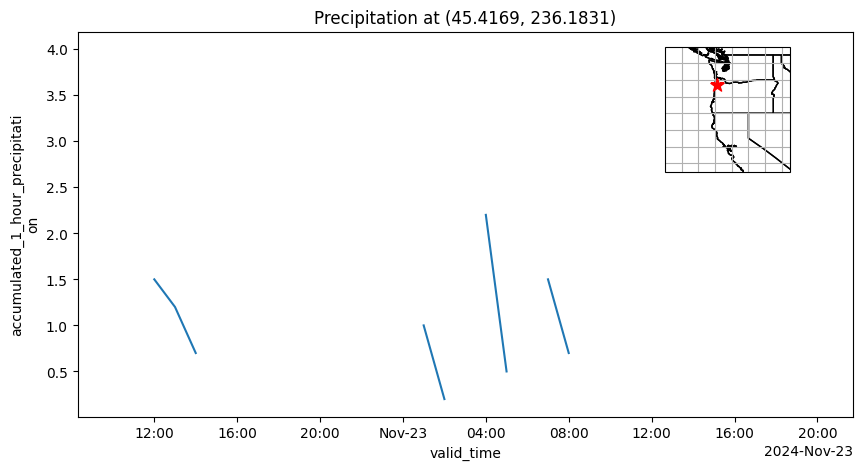

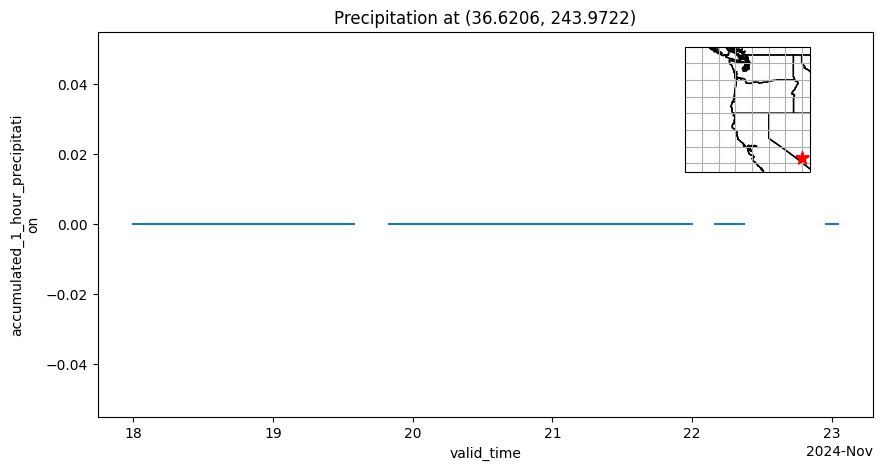

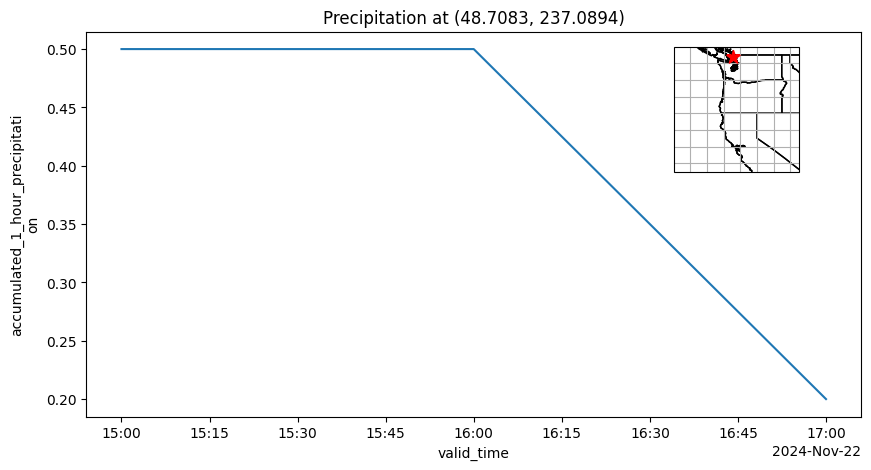

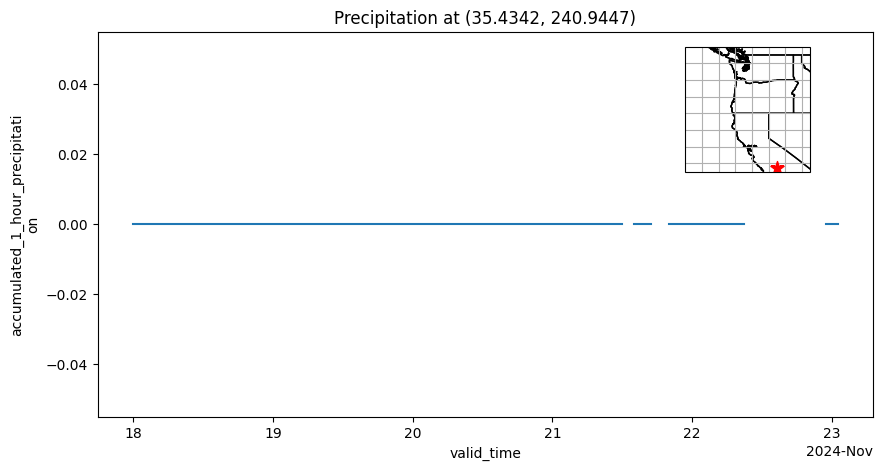

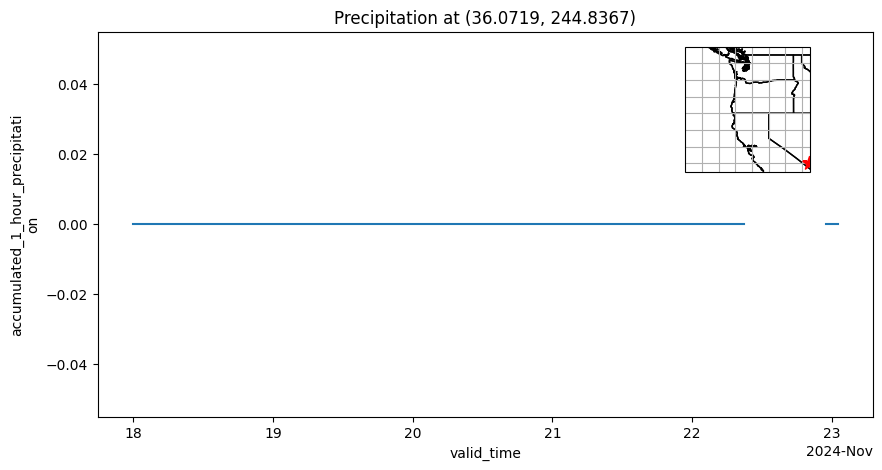

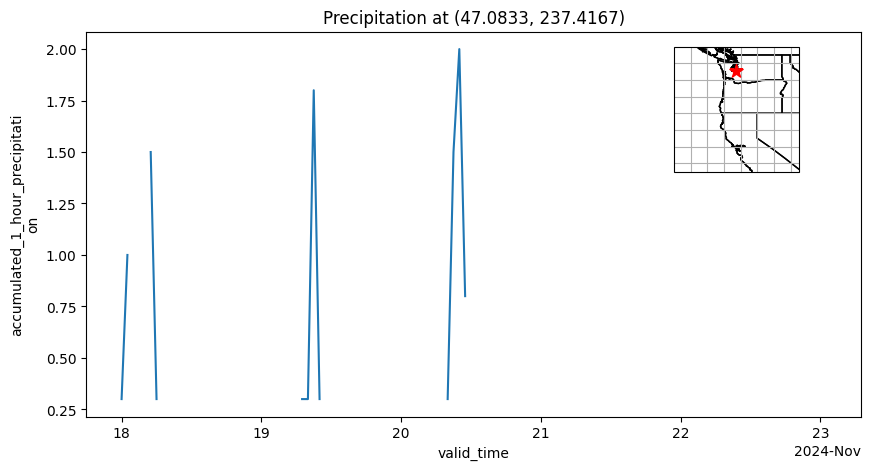

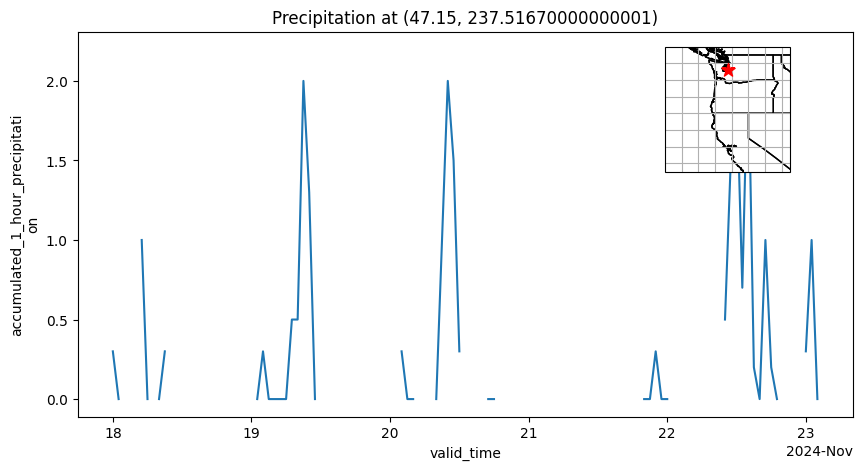

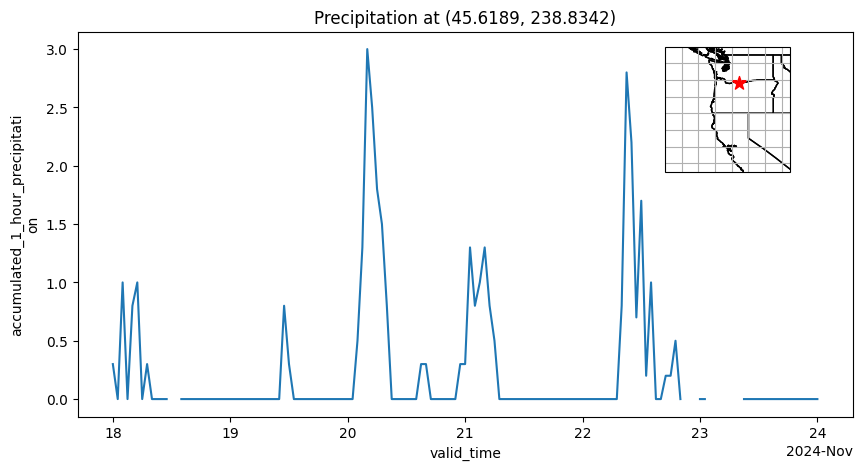

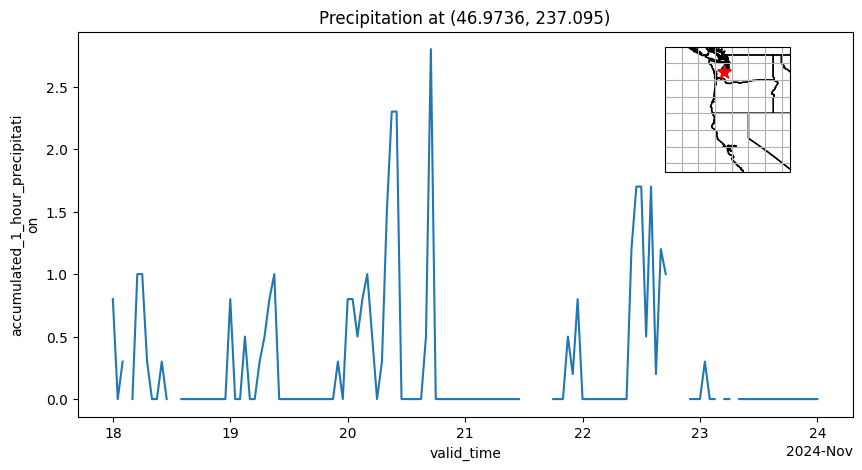

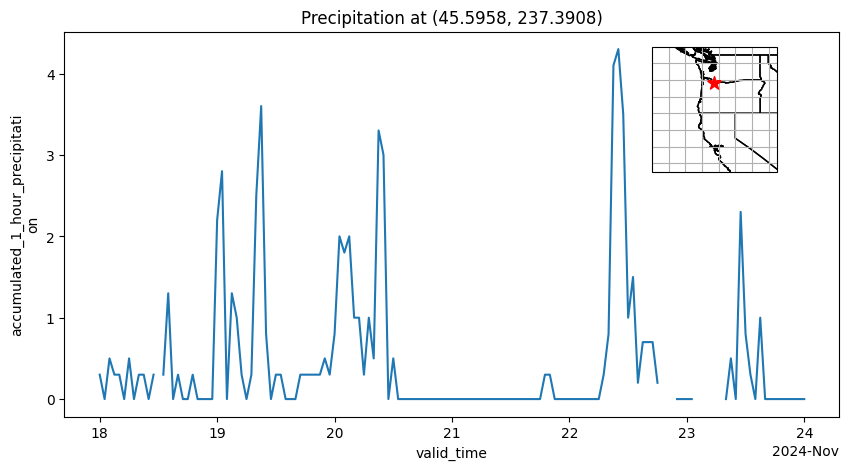

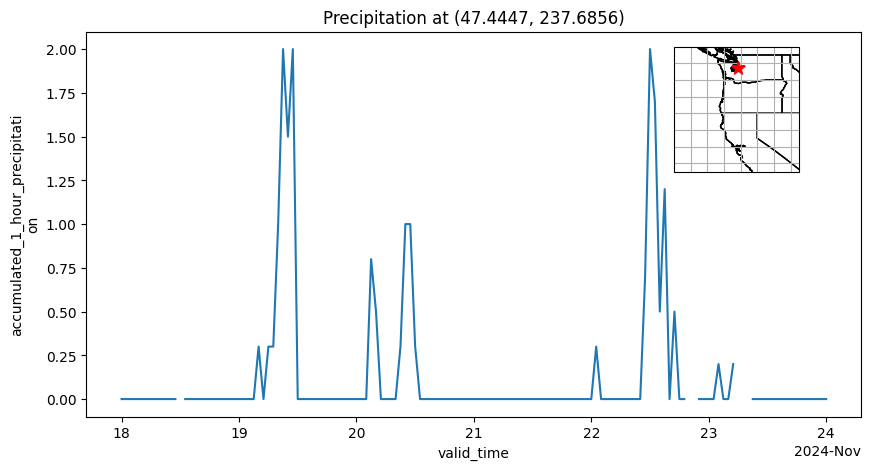

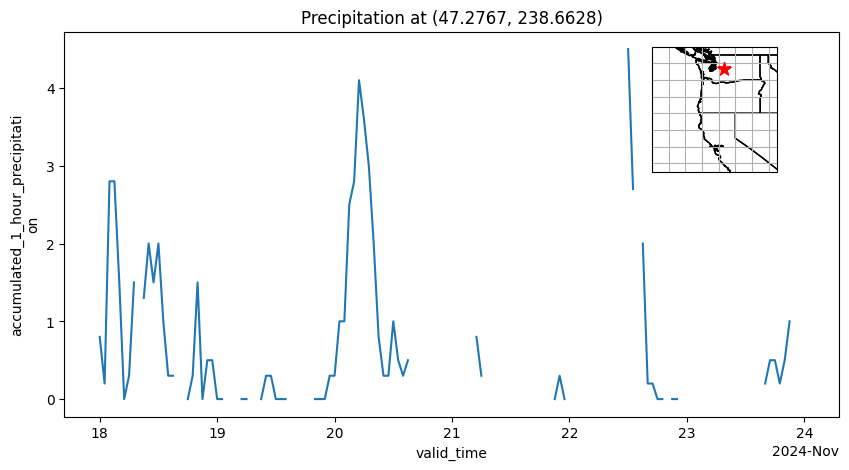

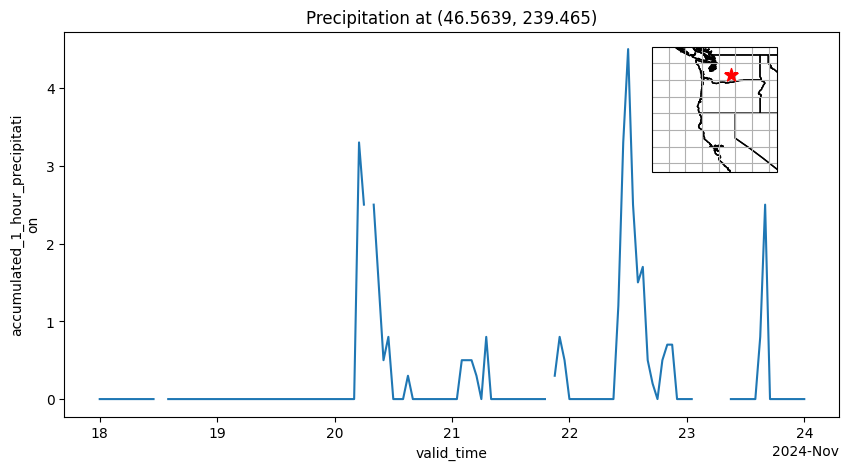

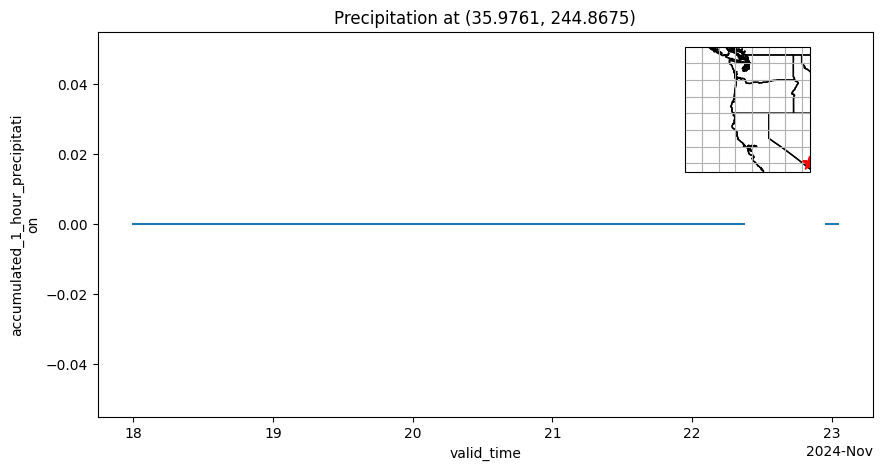

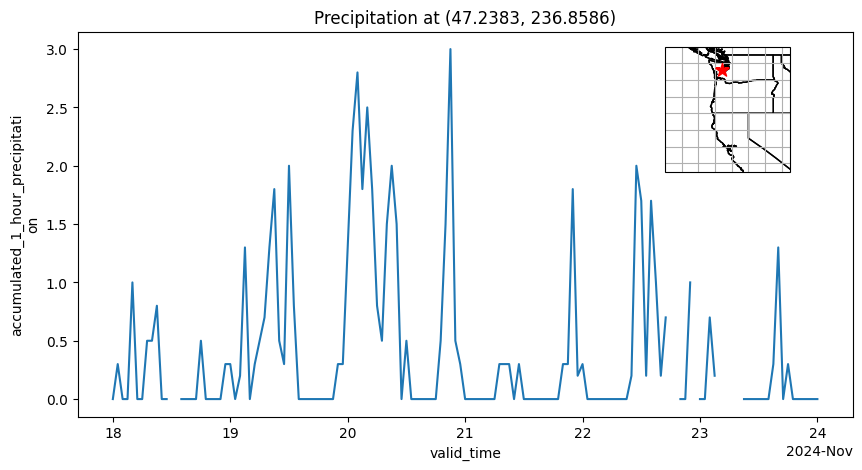

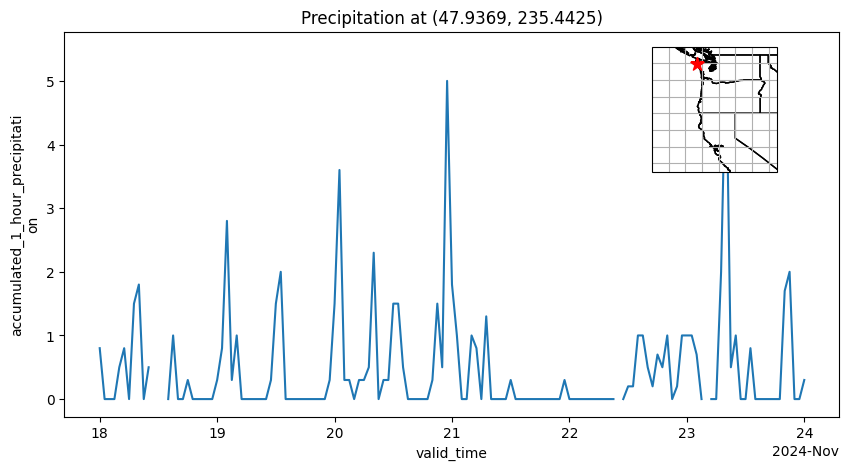

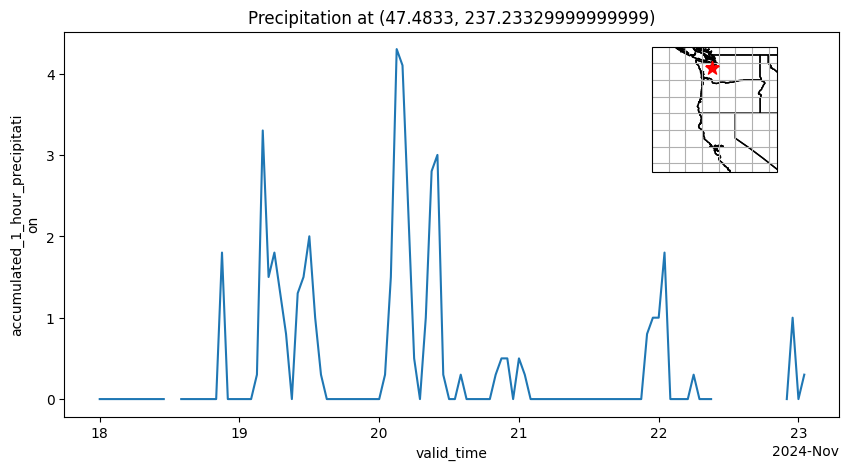

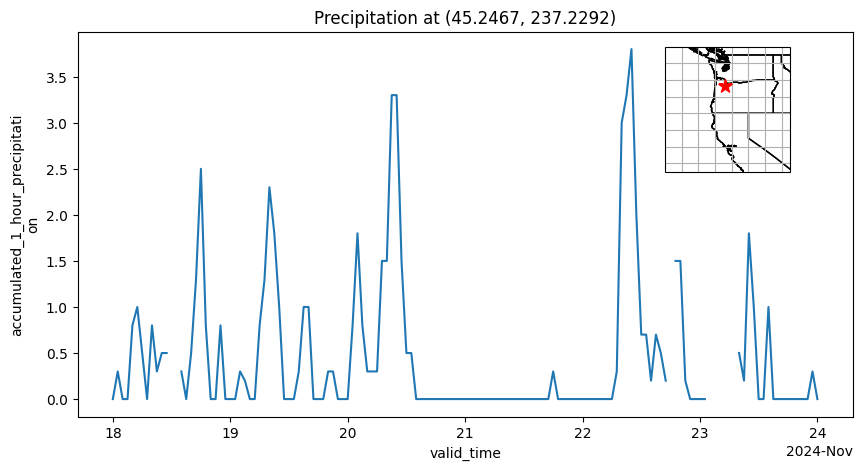

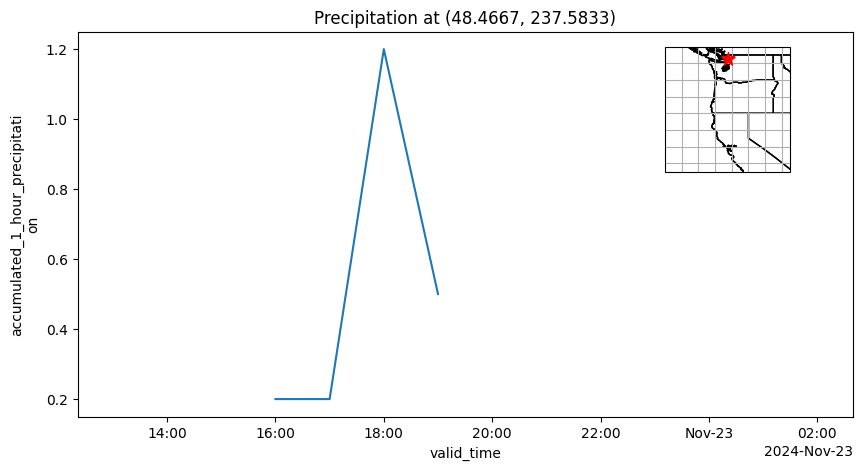

In [58]:
for location in prepared_ghcn['accumulated_1_hour_precipitation'].dropna(dim='location', how='all').location.values:
    fig = plt.figure(figsize=(10, 5))
    
    # Main time series plot
    ax1 = plt.gca()
    prepared_ghcn['accumulated_1_hour_precipitation'].dropna(dim='location', how='all').sel(location=location).plot(ax=ax1)
    ax1.set_title(f'Precipitation at {location}')
    
    # Create inset map
    ax2 = plt.axes([0.65, 0.6, 0.25, 0.25], projection=ccrs.PlateCarree())
    ax2.coastlines()
    ax2.add_feature(cfeature.STATES)
    ax2.scatter(
        prepared_ghcn.longitude.sel(location=location),
        prepared_ghcn.latitude.sel(location=location),
        c='red',
        marker='*',
        s=100,
        transform=ccrs.PlateCarree(),
        zorder=10
    )
    ax2.set_extent([
        bounded_location.min_lon, 
        bounded_location.max_lon,
        bounded_location.min_lat, 
        bounded_location.max_lat
    ])
    gl = ax2.gridlines(draw_labels=False)
    
    plt.show()

# Metrics

## Load in virtualizarr

In [116]:
# sample data, single forecast, FCN
# !uv pip install virtualizarr
# from virtualizarr import open_virtual_dataset
# import time
# time_start = time.time()
# virtual_dataset = open_virtual_dataset('s3://noaa-oar-mlwp-data/FOUR_v200_GFS/2024/1112/FOUR_v200_GFS_2024111212_f000_f240_06.nc',
#                                        decode_times=True,
#                                        loadable_variables=['time','latitude','longitude','level'],
#                                        reader_options={'storage_options': {'anon': True}})

# # in case 0's are nans for some reason!
# for n in ['latitude','longitude']:
#     virtual_dataset[n] = virtual_dataset[n].fillna(0)
# virtual_dataset.virtualize.to_kerchunk('fcn_gfs_sample_2024111200.parq',format='parquet')
# time_end = time.time()
# print(f"Time taken: {time_end - time_start} seconds")
storage_options = {
    "remote_protocol": 's3',
    "remote_options": {"anon": True},
}  # options passed to fsspec
open_dataset_options: dict = {"chunks": {}}  # opens passed to xarray

fcn_ds_lazy = xr.open_dataset(
    'fcn_gfs_sample_2024111200.parq',
    engine="kerchunk",
    storage_options=storage_options,
    open_dataset_options=open_dataset_options,
)
fcn_ds = fcn_ds_lazy.compute()
for n in ['latitude','longitude']:
    fcn_ds[n] = fcn_ds[n].fillna(0)
fcn_ds = fcn_ds.rename({'msl': 'mean_sea_level_pressure', 
                              't': 'temperature', 
                              't2': '2m_temperature',
                              'u': 'u_component_of_wind', 
                              'v': 'v_component_of_wind', 
                              'z': 'geopotential',
                              'u10': '10m_u_component_of_wind',
                              'v10': '10m_v_component_of_wind',
                              'tcwv': 'total_column_water_vapour',
                              'r': 'relative_humidity',
                              })
fcn_ds = fcn_ds.assign_coords(fhour=('time',calculate_forecast_hours(fcn_ds)))
fcn_ds = fcn_ds[['u_component_of_wind', 'v_component_of_wind','relative_humidity','temperature']]
fcn_ds['surface_standard_pressure'] = calculate_pressure_at_surface(era5.isel(time=1000000)['geopotential_at_surface'])
fcn_ds = fcn_ds.transpose('level','time','latitude','longitude')
fcn_ds['specific_humidity'] = specific_humidity_from_relative_humidity(fcn_ds['relative_humidity']/100, fcn_ds['temperature'], fcn_ds['level'])
fcn_ds = fcn_ds.sel(latitude=slice(50,35),longitude=slice(230,245)).sel(time=pd.date_range('2024-11-20 00:00','2024-11-22 00:00',freq='6h'))

/tmp/ipykernel_2207/2934626373.py:43: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  fcn_ds = fcn_ds.assign_coords(fhour=('time',calculate_forecast_hours(fcn_ds)))


In [163]:
ivt_forecast_ds = calculate_ivt(fcn_ds)
ivt_forecast_ds['ar_mask'] = create_atmospheric_river_mask(ivt_forecast_ds)
ivt_forecast_ds['ar_land_intersection'] = find_land_intersection(ivt_forecast_ds['ar_mask']).tp

In [144]:
timestep_ds = ivt_forecast_ds.sel(latitude=slice(50,35),longitude=slice(230,245)).sel(time=pd.date_range('2024-11-20 00:00','2024-11-22 00:00',freq='6h'))
mask_timestep_ds = mask_ds.sel(latitude=slice(50,35),longitude=slice(230,245)).sel(time=pd.date_range('2024-11-20 00:00','2024-11-22 00:00',freq='6h'))
land_mask_timestep_ds = land_mask_intersection_ds.tp.sel(latitude=slice(50,35),longitude=slice(230,245)).sel(time=pd.date_range('2024-11-20 00:00','2024-11-22 00:00',freq='6h'))

## Plot function

In [30]:
def plot_ivt_and_mask(ivt_ds, ivt_laplacian_intersection, time, fig=None, ax=None):
    if fig is None:
        fig = plt.figure(figsize=(15, 10))
    if ax is None:
        ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.1)
    ax.add_feature(cfeature.OCEAN, alpha=0.1)

    # create the new map
    cmap = ['#ffffff','#bde6fa','#7bbae7','#4892bd','#49ae62','#a7d051','#f9d251','#f7792f','#e43d28','#c11b24','#921318']
    # cmap = plt.cm.cubehelix_r(np.linspace(0, 1, 12))  # 12 colors for 0-1100 range in 100 unit steps
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cubehelix', cmap)
    bounds = np.arange(0, 1200, 100)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    im = ivt_ds['integrated_vapor_transport'].plot(ax=ax, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,add_colorbar=False)
    # ivt_ds['integrated_vapor_transport_laplacian'].plot(ax=ax, transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='RdBu_r')
    # ivt_ds['integrated_vapor_transport_laplacian'].plot.contour(levels=[8],ax=ax, transform=ccrs.PlateCarree(),colors='black',linewidths=2)
    ivt_laplacian_intersection.plot.contour(levels=[0.5],ax=ax, transform=ccrs.PlateCarree(),colors='black',linewidths=2)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    cbar = fig.colorbar(im, cax=cax, label="Integrated Vapor Transport (kgm^-1s^-1)")
    cbar.set_label("Integrated Vapor Transport (kgm^-1s^-1)", size=14)
    cbar.ax.tick_params(labelsize=12)
    ax.set_title(f'ERA5 Integrated Vapor Transport and Atmospheric River Mask, valid {time.strftime("%Y-%m-%d %H:%M")}', loc='left')
    plt.show()

## Animation

ValueError: different number of dimensions on data and dims: 2 vs 3

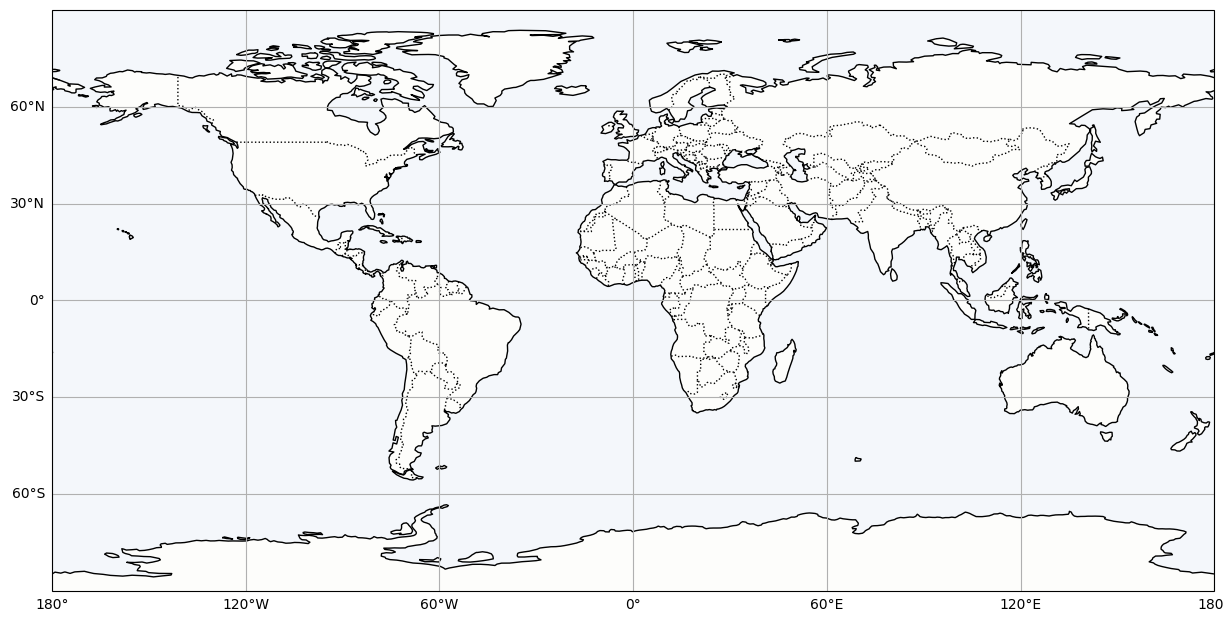

In [51]:
# # Create figure and axes
# fig = plt.figure(figsize=(15, 10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# gl = ax.gridlines(draw_labels=True)
# gl.right_labels = False
# gl.top_labels = False
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.LAND, alpha=0.1)
# ax.add_feature(cfeature.OCEAN, alpha=0.1)

# # Create colormap
# cmap = ['#ffffff','#bde6fa','#7bbae7','#4892bd','#49ae62','#a7d051','#f9d251','#f7792f','#e43d28','#c11b24','#921318']
# cmap = mcolors.LinearSegmentedColormap.from_list('custom_cubehelix', cmap)
# bounds = np.arange(0, 1200, 100)
# norm = mcolors.BoundaryNorm(bounds, cmap.N)

# # Initialize first frame
# ivt_forecast_ds = calculate_ivt(fcn_ds.isel(time=0))
# mask_ds = create_atmospheric_river_mask(ivt_forecast_ds)
# time = pd.to_datetime(fcn_ds.time.isel(time=0).values)

# # Create initial plot
# im = ax.pcolormesh(ivt_forecast_ds.longitude, ivt_forecast_ds.latitude, 
#                    ivt_forecast_ds['integrated_vapor_transport'],
#                    transform=ccrs.PlateCarree(),
#                    cmap=cmap, norm=norm)

# contour_data = mask_ds.values
# contour = ax.contour(mask_ds.longitude, mask_ds.latitude, contour_data,
#                      levels=[0.5], colors='black', linewidths=2,
#                      transform=ccrs.PlateCarree())

# # Add colorbar
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
# cbar = fig.colorbar(im, cax=cax, label="Integrated Vapor Transport (kgm^-1s^-1)")
# cbar.set_label("Integrated Vapor Transport (kgm^-1s^-1)", size=14)
# cbar.ax.tick_params(labelsize=12)
# title = ax.set_title((f'FCN Integrated Vapor Transport and Atmospheric River Mask\n'
#                      f'Initialized {pd.to_datetime(fcn_ds.attrs["initialization_time"]).strftime("%Y-%m-%d %H:%M")}\n'
#                      'Forecast Hour 0\n'
#                      f'Valid {time.strftime("%Y-%m-%d %H:%M")}'
#                      ), loc='left')

# def update(t):
#     # Clear previous contours
#     for coll in ax.collections[1:]:
#         coll.remove()
        
#     # Update data
#     ivt_forecast_ds = calculate_ivt(fcn_ds.sel(time=t))
#     mask_ds = create_atmospheric_river_mask(ivt_forecast_ds)
#     fhour = int((pd.to_datetime(t) - pd.to_datetime(fcn_ds.attrs["initialization_time"])).total_seconds() / 3600)
#     # Update title
#     title.set_text((f'FCN Integrated Vapor Transport and Atmospheric River Mask\n'
#                      f'Initialized {pd.to_datetime(fcn_ds.attrs["initialization_time"]).strftime("%Y-%m-%d %H:%M")}\n'
#                      f'Forecast Hour {fhour}\n'
#                      f'Valid {pd.to_datetime(t).strftime("%Y-%m-%d %H:%M")}'
#                      ))
    
#     # Update pcolormesh
#     im = ax.pcolormesh(ivt_forecast_ds.longitude, ivt_forecast_ds.latitude, 
#                     ivt_forecast_ds['integrated_vapor_transport'],
#                     transform=ccrs.PlateCarree(),
#                     cmap=cmap, norm=norm)
        
#     # Update contour
#     ax.contour(mask_ds.longitude, mask_ds.latitude, mask_ds.values,
#                levels=[0.5], colors='black', linewidths=2,
#                transform=ccrs.PlateCarree())
    
#     return im,

# # Create animation
# anim = animation.FuncAnimation(
#     fig,
#     update,
#     frames=fcn_ds.time.values,
#     interval=200,
#     blit=False
# )

# # Save animation
# anim.save('AR_mask_test.gif', writer='pillow', fps=5)
# plt.close()

## MAE of Total Event Precipitation on Intersecting AR/Land Points

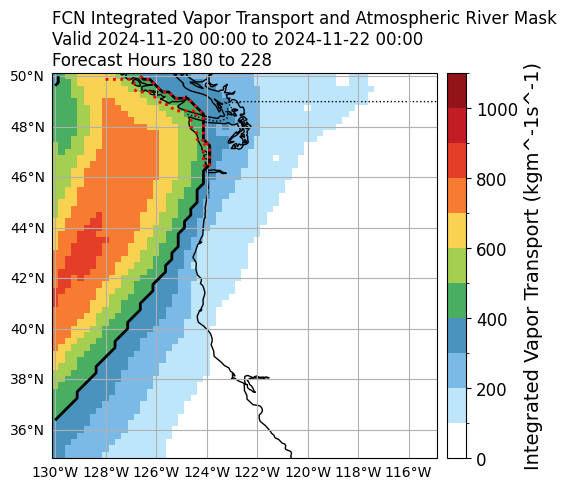

In [41]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, alpha=0.1)
ax.add_feature(cfeature.OCEAN, alpha=0.1)

# Create colormap
cmap = ['#ffffff','#bde6fa','#7bbae7','#4892bd','#49ae62','#a7d051','#f9d251','#f7792f','#e43d28','#c11b24','#921318']
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cubehelix', cmap)
bounds = np.arange(0, 1200, 100)
norm = mcolors.BoundaryNorm(bounds, cmap.N)


# Create initial plot
im = ax.pcolormesh(timestep_ds.longitude, timestep_ds.latitude, 
                   timestep_ds['integrated_vapor_transport'].max(dim='time'),
                   transform=ccrs.PlateCarree(),
                   cmap=cmap, norm=norm)

contour_data = mask_timestep_ds.max(dim='time').values
contour = ax.contour(mask_timestep_ds.longitude, mask_timestep_ds.latitude, contour_data,
                     levels=[0.5], colors='black', linewidths=2,
                     transform=ccrs.PlateCarree())

intersection_data = land_mask_timestep_ds.max(dim='time').values
intersection = ax.contour(land_mask_timestep_ds.longitude, land_mask_timestep_ds.latitude, intersection_data,
                     levels=[0.5], colors='red', linewidths=2, linestyles='dotted',
                     transform=ccrs.PlateCarree())

t0 = pd.date_range('2024-11-20 00:00','2024-11-22 00:00',freq='6h')[0]
t1 = pd.date_range('2024-11-20 00:00','2024-11-22 00:00',freq='6h')[-1]
fhour_0 = int((pd.to_datetime(t0) - pd.to_datetime(fcn_ds.attrs["initialization_time"])).total_seconds() / 3600)
fhour_1 = int((pd.to_datetime(t1) - pd.to_datetime(fcn_ds.attrs["initialization_time"])).total_seconds() / 3600)
title = ax.set_title((f'FCN Integrated Vapor Transport and Atmospheric River Mask\n'
                    f'Valid {pd.to_datetime(t0).strftime("%Y-%m-%d %H:%M")} to {pd.to_datetime(t1).strftime("%Y-%m-%d %H:%M")}\n'
                    f'Forecast Hours {fhour_0} to {fhour_1}'
                    ), loc='left')
# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
cbar = fig.colorbar(im, cax=cax, label="Integrated Vapor Transport (kgm^-1s^-1)")
cbar.set_label("Integrated Vapor Transport (kgm^-1s^-1)", size=14)
cbar.ax.tick_params(labelsize=12)

plt.show()

### Gridded (ERA5)

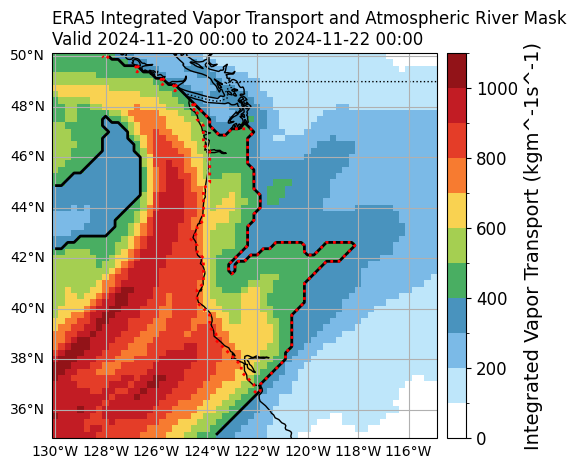

In [208]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, alpha=0.1)
ax.add_feature(cfeature.OCEAN, alpha=0.1)

# Create colormap
cmap = ['#ffffff','#bde6fa','#7bbae7','#4892bd','#49ae62','#a7d051','#f9d251','#f7792f','#e43d28','#c11b24','#921318']
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cubehelix', cmap)
bounds = np.arange(0, 1200, 100)
norm = mcolors.BoundaryNorm(bounds, cmap.N)


# Create initial plot
im = ax.pcolormesh(era5_event_ds.longitude, era5_event_ds.latitude, 
                   era5_event_ds['integrated_vapor_transport'].max(dim='time'),
                   transform=ccrs.PlateCarree(),
                   cmap=cmap, norm=norm)

contour_data = era5_event_ds['ar_mask'].max(dim='time').values
contour = ax.contour(era5_event_ds.longitude, era5_event_ds.latitude, contour_data,
                     levels=[0.5], colors='black', linewidths=2,
                     transform=ccrs.PlateCarree())

intersection_data = era5_event_ds['ar_land_intersection'].max(dim='time').values
intersection = ax.contour(era5_event_ds.longitude, era5_event_ds.latitude, intersection_data,
                     levels=[0.5], colors='red', linewidths=2, linestyles='dotted',
                     transform=ccrs.PlateCarree())

t0 = era5_event_ds.time.values[0]
t1 = era5_event_ds.time.values[-1]
title = ax.set_title((f'ERA5 Integrated Vapor Transport and Atmospheric River Mask\n'
                    f'Valid {pd.to_datetime(t0).strftime("%Y-%m-%d %H:%M")} to {pd.to_datetime(t1).strftime("%Y-%m-%d %H:%M")}'
                    ), loc='left')
# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
cbar = fig.colorbar(im, cax=cax, label="Integrated Vapor Transport (kgm^-1s^-1)")
cbar.set_label("Integrated Vapor Transport (kgm^-1s^-1)", size=14)
cbar.ax.tick_params(labelsize=12)

plt.show()

Check IFS/GFS

In [211]:
# set up overlap mask where the max values over the event overlap land
overlap_mask = era5_event_ds['ar_land_intersection'].max(dim='time')

# using IVT in place of APCP; FCN does not have APCP
mae(
    ivt_forecast_ds['integrated_vapor_transport'].where(overlap_mask,np.nan),
    era5_event_ds['integrated_vapor_transport'].where(overlap_mask,np.nan), 
    preserve_dims='time'
    ).compute()


<xarray.DataArray 'integrated_vapor_transport' (time: 9)> Size: 72B
array([186.97712464, 266.95798219, 256.15005215, 235.37840443,
       332.84748131, 327.60694116, 317.72068855, 309.99394796,
       308.35032059])
Coordinates:
  * time     (time) datetime64[ns] 72B 2024-11-20 ... 2024-11-22
    fhour    (time) timedelta64[ns] 72B 7 days 12:00:00 ... 9 days 12:00:00

## Lead Time of AR Signal on Land Intersection

This metric will look at longer lead time forecasts to determine when there was an initial signal for an atmospheric river in the domain, with a +-48 hour buffer

In [212]:
def find_max_fhour_of_valid_forecast(forecast_ds: xr.Dataset) -> np.timedelta64:
    """
    Find the maximum forecast hour that has an intersection between the AR mask and land.

    Args:
        input_land_ar_mask: xr.DataArray with the land and AR mask

    Returns:
        np.timedelta64: The maximum forecast hour that has an intersection between the AR mask and land in hours
    """
    time_reduced_mask = forecast_ds['ar_land_intersection'].sum(dim=['latitude','longitude'])
    return time_reduced_mask.where(time_reduced_mask > 0, drop=True).fhour.max().values.astype('timedelta64[h]')

find_max_fhour_of_valid_forecast(ivt_forecast_ds)

np.timedelta64(222,'h')

## Spatial Displacement Error (Center of Mass on AR/Land Intersection)

In [227]:
def determine_center_of_mass(data: xr.DataArray) -> tuple[float, float]:
    """
    Determine the center of mass of a data array.
    """
    com = center_of_mass(data)
    lat_coords = data.coords['latitude'].values
    lon_coords = data.coords['longitude'].values
    com_latitude = np.interp(com[0], np.arange(len(lat_coords)), lat_coords)
    com_longitude = np.interp(com[1], np.arange(len(lon_coords)), lon_coords)
    return com_latitude, com_longitude

def calculate_spatial_displacement(forecast_ds: xr.Dataset, analysis_ds: xr.Dataset) -> xr.Dataset:
    """
    Calculate the spatial displacement of the forecast and analysis datasets.

    Args:
        forecast_ds: xr.Dataset with forecast data and mask
        analysis_ds: xr.Dataset with validation data and mask

    Returns:
        xr.Dataset with the spatial displacement
    """
    analysis_com = determine_center_of_mass(era5_event_ds['integrated_vapor_transport'].where(era5_event_ds['ar_land_intersection'],0).max(dim='time'))
    forecast_com = determine_center_of_mass(ivt_forecast_ds['integrated_vapor_transport'].where(ivt_forecast_ds['ar_land_intersection'],0).max(dim='time'))

    displacement = haversine_distance(*analysis_com, *forecast_com)
    return displacement

calculate_spatial_displacement(ivt_forecast_ds, era5_event_ds)

np.float64(838.9635517056178)

## IOU/CSI On Predicted vs Actual AR Over Land

In [235]:
csi_predicted_vs_analysis_ar = cat.BinaryContingencyManager(
    era5_event_ds['ar_land_intersection'].max(dim='time'),
    ivt_forecast_ds['ar_land_intersection'].max(dim='time')
).transform().critical_success_index()